In [1]:
from keras.applications import VGG16 
conv_base = VGG16(weights='imagenet',
                 include_top=False, 
                 input_shape=(150, 150, 3))
conv_base.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [2]:
import os 
import numpy as np 
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/Users/developer/data/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20 


In [3]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0 
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch 
        i += 1 
        if i * batch_size >= sample_count:
            break
    return features, labels

In [4]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [6]:
from keras import models 
from keras import layers 
from keras import optimizers 

model = models.Sequential() 
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(train_features, train_labels,
                   epochs=30,
                   batch_size=20,
                   validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 833us/step - loss: 0.6053 - acc: 0.6580 - val_loss: 0.4316 - val_acc: 0.8320
Epoch 2/30
2000/2000 [==============================] - 2s 771us/step - loss: 0.4266 - acc: 0.8080 - val_loss: 0.3587 - val_acc: 0.8580
Epoch 3/30
2000/2000 [==============================] - 2s 765us/step - loss: 0.3540 - acc: 0.8460 - val_loss: 0.3201 - val_acc: 0.8800
Epoch 4/30
2000/2000 [==============================] - 2s 771us/step - loss: 0.3091 - acc: 0.8730 - val_loss: 0.2994 - val_acc: 0.8810
Epoch 5/30
2000/2000 [==============================] - 2s 776us/step - loss: 0.2891 - acc: 0.8865 - val_loss: 0.2846 - val_acc: 0.8870
Epoch 6/30
2000/2000 [==============================] - 2s 778us/step - loss: 0.2615 - acc: 0.9020 - val_loss: 0.2709 - val_acc: 0.8950
Epoch 7/30
2000/2000 [==============================] - 2s 787us/step - loss: 0.2451 - acc: 0.9070 - val_loss: 0.2705 - val_acc: 0.8910


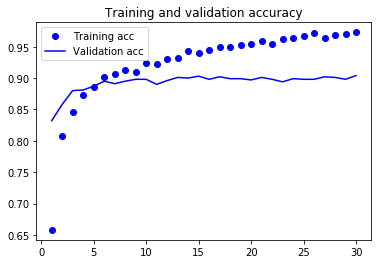

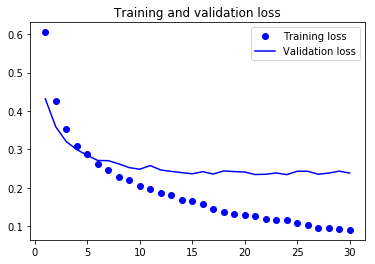

In [9]:
import matplotlib.pyplot as plt 
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()